# Groundwater SAD space

Let's pull some groundwater bodies from Queensland wetlands and see how they lie in SAD space.

## Load data

First load the Queensland springs dataset:

In [133]:
import geopandas as gpd
import h5py
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

%matplotlib inline

In [2]:
gde = gpd.read_file('qld_gde_surface_points.geojson')

In [100]:
buffered_gde = gde.copy()
buffered_gde = gpd.GeoDataFrame(buffered_gde, geometry=buffered_gde.buffer(100))

And the waterbodies info from LoadWaterbodies and SADRepresentation:

In [102]:
wbs = gpd.read_file('waterbodies_joined_drainage_basins.shp')

In [103]:
history = h5py.File('interpolated_waterbodies_by_division_and_basin_fixed.h5', 'r')

Almost all of the intersection between DEA Waterbodies and the springs set are in Paroo River, Murray-Darling Basin, so we'll look there.

In [104]:
features = history['Murray-Darling Basin']['PAROO RIVER']['sad_features'][()]

Join the GDE points with the waterbodies.

In [105]:
wbs_joined = gpd.sjoin(wbs, gde, how='inner', op='intersects')

In [106]:
wbs_paroo = wbs_joined[(wbs_joined.Division_ == 'Murray-Darling Basin') & (wbs_joined.BNAME == 'PAROO RIVER')]

In [110]:
len(wbs_joined.UID.unique())

21

## Springs in the feature space

Let's do PCA on the feature space and see if the springs appear with any structure.

In [111]:
pca = PCA().fit(features)

In [112]:
pca_features = pca.transform(features)

In [119]:
paroo_uids = [a.decode('ascii') for a in history['Murray-Darling Basin']['PAROO RIVER']['uid']]

In [124]:
spring_uids = {a for a in wbs_paroo.UID}

In [125]:
is_spring = [u in spring_uids for u in paroo_uids]

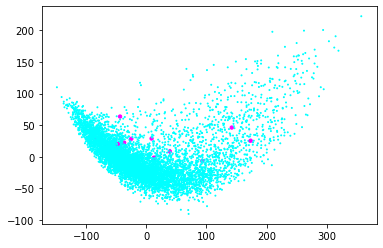

In [132]:
plt.scatter(pca_features[:, 0], pca_features[:, 1], s=np.array(is_spring) * 10 + 1, c=is_spring, cmap='cool')

None whatsoever!

## Nearest-neighbours

Grab the nearest neighbours for these and see what they look like.

In [134]:
kdtree = KDTree(features)

In [136]:
dists, neighbours = kdtree.query(features[is_spring], k=2)

In [137]:
dists = dists[:, 1]
neighbours = neighbours[:, 1]

In [143]:
neighbour_ids = [paroo_uids[i] for i in neighbours]

In [153]:
points = wbs.set_index('UID').loc[neighbour_ids].centroid.to_crs('EPSG:4326')

In [157]:
xs = points.x
ys = points.y

for x, y in zip(xs, ys):
    print(y, x)

-28.463651371578607 144.51209408392407
-28.765728304661792 144.29597585554654
-30.064869258763526 145.0774348177904
-29.997864903871893 144.21526532180062
-28.998229884708074 144.3297582060804
-28.153551995836935 144.96822472059566
-29.53321784893466 144.33452985117
-28.136789858122263 144.99837550391976
-28.703272473664075 144.2320340279026
-30.272821107576412 144.1971641543271
-29.137510138125638 145.27413954963376
-29.329234555411684 144.42058865918713
-28.772622948135584 144.8026279106437
-28.298733790788148 144.26589804699867


In [161]:
set(wbs_joined.UID) & set(neighbour_ids)

set()